In [1]:
library(bnlearn)
library(tidyverse)
library(graph)
library(gRbase)
library(gRain)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:b

In [2]:
Data<-read_csv("./data/output/Data_RASFF_EMA_new.csv") 

Data<-Data %>% filter(Data_source=="EMA")%>% select(-Data_source,-`Ct_country-name`) %>% rename(Fraud=Product_fraudtype,Product=Product_category,Origin=`Or_country-name`)


Data<-Data %>% mutate_if(is.numeric,as.character)

Data[is.na(Data)]<-"Missing data"





set.seed(0)
Sampled_rows<-sample(1:length(Data$Fraud),ceiling(length(Data$Fraud)*0.2),rep=FALSE)

BNdata_train<-Data[-Sampled_rows,]

BNdata_test<-Data[Sampled_rows,]

BNdata_train<-BNdata_train %>%  mutate_if(is.character,as.factor)

BNdata_test<-BNdata_test %>%  mutate_if(is.character,as.factor)


write.csv(BNdata_train,"./data/output/BNdata_train_EMA.csv",row.names = FALSE)
write.csv(BNdata_test,"./data/output/BNdata_test_EMA.csv",row.names = FALSE)

Rows: 441 Columns: 6

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Data_source, Product_category, Or_country-name, Ct_country-name, Pr...
dbl (1): Year


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



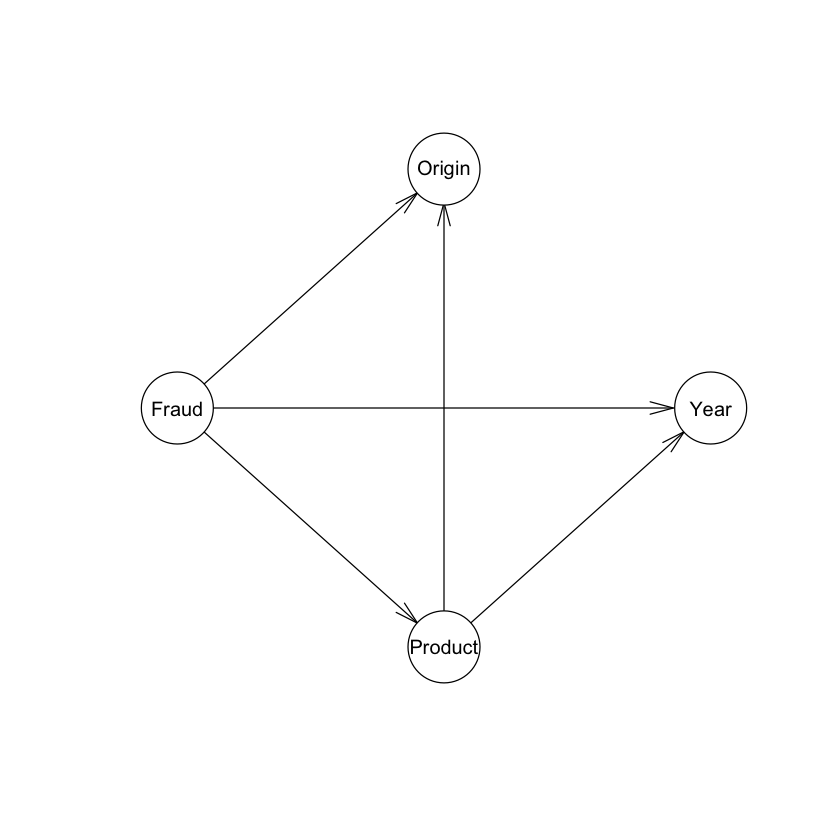

In [3]:
BNdata_train<-as.data.frame(BNdata_train)
BNdata_test<- as.data.frame(BNdata_test)

#structure leaning
BN_structure<- tree.bayes(BNdata_train,'Fraud')

## test other learning algorithms #

#BN_structure<-gs(BNdata_train)  ### Grow-Shrink (GS) Constraint-based algorithm
#BN_structure<-iamb(BNdata_train)### The incremental association Markov boundary algorithm
#BN_structure<-hc(BNdata_train)### Hill climbing algorithm

graphics::plot(BN_structure)
#graphviz.plot(BN_structure, shape = "ellipse")


In [4]:
BIC(BN_structure, BNdata_train)

[1] -2638.822

In [5]:
## parameter learning
BN_trained<-bn.fit(x=BN_structure,data=BNdata_train,method = "bayes")

## convert to gRain
fitted.grain = as.grain(BN_trained)

In [6]:
#Retrieve marginal probability distribution of each node
Mprobs = querygrain(fitted.grain, type = "marginal")
Mprobs 

$Fraud
Fraud
   Artificial enhancement/Improvement Smuggling-Mislabelling-Origin Masking 
                            0.2380952                             0.2640693 
                Substitution-Dilution 
                            0.4978355 

$Product
Product
     Alcoholic  Confectionary          Dairy   Fish_Seafood         Fruits 
    0.07892108     0.03996004     0.18281718     0.10489510     0.01398601 
Grain_products   Herbs_spices          Honey           Meat      Oils_Fats 
    0.06593407     0.09190809     0.09190809     0.05294705     0.16983017 
       Poultry            Tea     Vegetables 
    0.01398601     0.01398601     0.07892108 

$Year
Year
      2008       2009       2010       2011       2013       2014       2015 
0.09235209 0.07936508 0.11832612 0.22222222 0.01443001 0.06637807 0.28715729 
      2016       2017 
0.09235209 0.02741703 

$Origin
Origin
     Argentina      Australia     Bangladesh         Brazil          China 
    0.01367054     0.01367054     0.01367054     0.01367054     0.23444976 
         Ghana          India           Iran        Ireland         Israel 
    0.01367054     0.33834586     0.01367054     0.01367054     0.01367054 
         Italy         Mexico          Spain         Taiwan         Turkey 
    0.03964457     0.01367054     0.05263158     0.02665755     0.02665755 
        Uganda United Kingdom  United States        Vietnam 
    0.01367054     0.02665755     0.10457963     0.01367054

In [7]:
## internal validation: confusion matrix
pred_in <- predict(fitted.grain , response = c("Fraud"), newdata = BNdata_train, type = "class")

pred_in <- as.data.frame(pred_in)
table(BNdata_train$Fraud,pred_in$Fraud)
Detection_probability_inter<-sum(diag(table(BNdata_train$Fraud,pred_in$Fraud)))/
  sum(table(BNdata_train$Fraud,pred_in$Fraud))
Detection_probability_inter

                                       
                                        Artificial enhancement/Improvement
  Artificial enhancement/Improvement                                    17
  Smuggling-Mislabelling-Origin Masking                                  1
  Substitution-Dilution                                                  1
                                       
                                        Smuggling-Mislabelling-Origin Masking
  Artificial enhancement/Improvement                                        1
  Smuggling-Mislabelling-Origin Masking                                    19
  Substitution-Dilution                                                     2
                                       
                                        Substitution-Dilution
  Artificial enhancement/Improvement                        0
  Smuggling-Mislabelling-Origin Masking                     0
  Substitution-Dilution                                    35

[1] 0.9342105

In [8]:
## external validation: confusion matrix
pred_ex <- predict(fitted.grain, response = c("Fraud"), newdata=BNdata_test, type = "class")

pred_ex <- as.data.frame(pred_ex)

table(BNdata_test$Fraud,pred_ex$Fraud)
Detection_probability_exter<-sum(diag(table(BNdata_test$Fraud,pred_ex$Fraud)))/sum(table(BNdata_test$Fraud,pred_ex$Fraud))
Detection_probability_exter

                                       
                                        Artificial enhancement/Improvement
  Artificial enhancement/Improvement                                     2
  Smuggling-Mislabelling-Origin Masking                                  2
  Substitution-Dilution                                                  4
                                       
                                        Smuggling-Mislabelling-Origin Masking
  Artificial enhancement/Improvement                                        1
  Smuggling-Mislabelling-Origin Masking                                     0
  Substitution-Dilution                                                     1
                                       
                                        Substitution-Dilution
  Artificial enhancement/Improvement                        0
  Smuggling-Mislabelling-Origin Masking                     1
  Substitution-Dilution                                     8

[1] 0.5263158